In [1]:
import torch
from torch import Tensor, nn
from math import ceil
from torch.autograd import Function

/Users/matte/Library/CloudStorage/GoogleDrive-matteobonotto90@gmail.com/My Drive/Colab_Notebooks/triton/triton/venv/lib/python3.10/site-packages/torch/_subclasses/functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:81.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


```math
silu(x) = x * \sigma(x) = \frac{x}{1+e^{-x}}
```

In [ ]:
def naive_silu(x:Tensor) -> Tensor:
    sigma = 1 / (1 + torch.exp(-x))
    return x * sigma

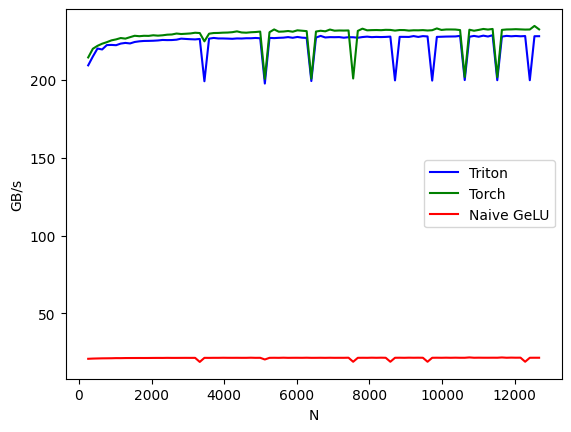

softmax-performance:
          N      Triton       Torch  Naive GeLU
0     256.0  209.483773  214.560654   20.869780
1     384.0  215.143102  220.144687   21.009381
2     512.0  220.298216  222.021202   21.087992
3     640.0  219.690003  223.396919   21.160203
4     768.0  222.500012  224.374322   21.189931
5     896.0  222.613044  225.543211   21.222886
6    1024.0  222.435587  226.169785   21.302826
7    1152.0  223.475744  227.041093   21.288595
8    1280.0  223.907290  226.655294   21.349037
9    1408.0  223.561183  227.594923   21.363669
10   1536.0  224.498421  228.492180   21.374096
11   1664.0  224.928663  228.213174   21.386401
12   1792.0  225.159484  228.480844   21.379106
13   1920.0  225.207004  228.417789   21.392515
14   2048.0  225.299638  228.816757   21.424708
15   2176.0  225.481058  228.567168   21.437992
16   2304.0  225.799300  228.798926   21.427905
17   2432.0  225.702885  229.190308   21.473031
18   2560.0  225.745491  229.320169   21.445534
19   2688.0  225.97

In [ ]:
import triton
import triton.language as tl

DEVICE = torch.device('cuda')
import math


@triton.jit
def silu_kernel_fwd(x_poiter, act_pointer, sigma_pointer, num_elements, block_size: tl.constexpr):

    pid = tl.program_id(axis=0)
    pointers = pid*block_size + tl.arange(0, block_size)
    mask = pointers < num_elements

    x = tl.load(x_poiter+pointers, mask)
    sigma = 1 / (1 + tl.exp(-x))
    chunk_res = x * sigma

    tl.store(act_pointer+pointers, chunk_res, mask)
    tl.store(sigma_pointer+pointers, chunk_res, mask)


def silu_triton_fwd(x:Tensor, block_size:int=2048) -> Tensor:

    num_elements = x.numel()
    grid = ceil(num_elements / block_size),

    act = torch.empty_like(x).to(x.device)
    sigma = torch.empty_like(x).to(x.device)

    silu_kernel_fwd[grid](x, act, sigma, num_elements, block_size)
    return act, sigma



### performance
x = torch.rand(100).to(DEVICE)
triton.testing.assert_close(silu_triton_fwd(x), naive_silu(x))

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_silu'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive SiLU"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.nn.functional.silu(x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: silu_triton_fwd(x)[0])
    if provider == 'naive_silu':
        ms = triton.testing.do_bench(lambda: naive_silu(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

In [75]:
layer = nn.SiLU()

class SiLUFunction(Function):
    @staticmethod
    def forward(ctx, x:Tensor) -> Tensor:
        sigma = 1 / (1 + torch.exp(-x))
        ctx.save_for_backward(x, sigma)
        return x * sigma
    
    @staticmethod
    def backward(ctx, grad_output):
        x, sigma,  = ctx.saved_tensors
        return grad_output * sigma * (1 + x * (1 - sigma))
    
class SiLUFunctionCustomModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        in_shape = x.shape
        return SiLUFunction.apply(x.view(x.numel())).view(in_shape)
    
silu_custom = SiLUFunctionCustomModule()
        

In [76]:
### Check forward pass
x = torch.rand(8, 16, requires_grad=True)
assert torch.allclose(naive_silu(x), SiLUFunction.apply(x))


### Check backward pass
x = torch.rand(8, 16, requires_grad=True)

# Forward pass
out_a = silu_custom(x)
out_b = naive_silu(x)

grad_output = torch.randn_like(out_a)

# Backward pass A
grads_a, = torch.autograd.grad(out_a, (x), grad_outputs=grad_output, retain_graph=True)

# Backward pass B
grads_b, = torch.autograd.grad(out_b, (x), grad_outputs=grad_output, retain_graph=True)

for i, (ga, gb) in enumerate(zip(grads_a, grads_b)):
    max_diff = (ga - gb).abs().max().item()
    print(f"Gradient {i}: max diff = {max_diff}")
    assert torch.allclose(ga, gb, atol=1e-6), f"Mismatch in grad {i}"
    


Gradient 0: max diff = 1.1920928955078125e-07
Gradient 1: max diff = 5.960464477539063e-08
Gradient 2: max diff = 1.1920928955078125e-07
Gradient 3: max diff = 2.384185791015625e-07
Gradient 4: max diff = 5.960464477539063e-08
Gradient 5: max diff = 1.1920928955078125e-07
Gradient 6: max diff = 1.1920928955078125e-07
Gradient 7: max diff = 1.1920928955078125e-07


In [ ]:

@triton.jit
def silu_kernel_bwd(
    x_pointer:Tensor, 
    sigma_pointer:Tensor, 
    grad_output_pointer:Tensor, 
    dL_pointer: Tensor,
    num_elements: int, 
    block_size:tl.constexpr
):
    pid = pl.program_id(axis=0)

    pointer_offset = pid*block_size + tl.arange(0, block_size)
    mask = pointer_offset < num_elements

    grad_output = tl.load(grad_output_pointer+pointer_offset, mask)
    sigma = tl.load(sigma_pointer+pointer_offset, mask)
    x = tl.load(x_pointer+pointer_offset, mask)

    dL = grad_output * sigma * (1 + x * (1 - sigma))
    tl.store(dL_pointer+pointer_offset, dL, mask)


def silu_triton_bwd(x:Tensor, sigma:Tensor, grad_output:Tensor, block_size:int=2048) -> Tensor:
    dL = torch.empty_like(grad_output)
    num_elements = dL.numel()
    grid = ceil(num_elements / block_size)
    silu_kernel_bwd[grid](x, sigma, grad_output, dL, num_elements, block_size)
    return dL


class SiLUFunctionTriton(Function):
    @staticmethod
    def forward(ctx, x:Tensor) -> Tensor:
        x, sigma = silu_triton_fwd(x)
        ctx.save_for_backward(x, sigma)
        return x * sigma
    
    @staticmethod
    def backward(ctx, grad_output):
        """ dL = grad_output * sigma * (1 + x * (1 - sigma)) """
        x, sigma,  = ctx.saved_tensors
        dL = silu_triton_bwd(x, sigma, grad_output)
        return dL
    
class SiLUModuleTriton(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        in_shape = x.shape
        return SiLUFunctionTriton.apply(x.view(x.numel())).view(in_shape)
        

NameError: name 'triton' is not defined

In [ ]:
### test that the results are correct
# input tensor
x = torch.rand(32, 64)
dy = .1 * torch.randn_like(x)
x.requires_grad = True

# fwd pass
act_torch = nn.functional.silu(x)
act_triton, sigma = silu_triton_fwd(x)

# bkw pass (torch)
act_triton = silu_triton_bwd(x, sigma, dy)
dx_triton  = x.grad.clone()
x.grad = None

# bwd pass (triton)
act_torch.backward(dy, retain_graph=True)
dx_torch  = x.grad.clone()

# compare
print(dx_torch - dx_triton)



### Compare performance
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=["Triton", "Torch"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

def benchmark(M, N, provider, mode='backward'):
    print(f"Testing mode: {mode}")
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8] # Performance percentile to return in addition to the median.


    def y_fwd():
        if provider == 'torch':
            return triton.testing.do_bench(lambda: torch.nn.functional.silu(x))
        if provider == 'triton':
            return triton.testing.do_bench(lambda: silu_triton_fwd(x)[0])
    
    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True), 
            quantiles=quantiles,
            grad_to_none=[x], 
            rep=500
        )
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)